# Pixel classification using Scikit image
Pixel classification is a technique for assigning pixels to multiple classes. If there are two classes (object and background), we are talking about binarization. In this example we use a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) for pixel classification.

See also
* [Scikit-image random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Classification of land cover by Chris Holden](https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)


In [ ]:
# !pip install scikit-image
# !pip install matplotlib
# !pip install nd2
# !pip install -U scikit-learn

In [1]:
from skimage.io import imread, imshow,imsave
import nd2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


**Give the model a meaningful name**

In [7]:
filename = 'transwell_denoised_2_categories_Mutant.pkl'

**Give the manual labeled data a meaningful name**

In [14]:
manual_labels_filename = "manual_annotations_transwell_denoised_Mutant-3-1.tif"

**If existant: Load the denoised img**

In [5]:
img = imread('competition_2_WTmScarlet_dwspFmNeonGreen/TW_growth/denoised/dwspF_C1-MAX_20230424_5hpif_mix2_WTmScarlet_dwspFmNeonGreen_ours_R3_003-1.tif')

(1200, 1200)

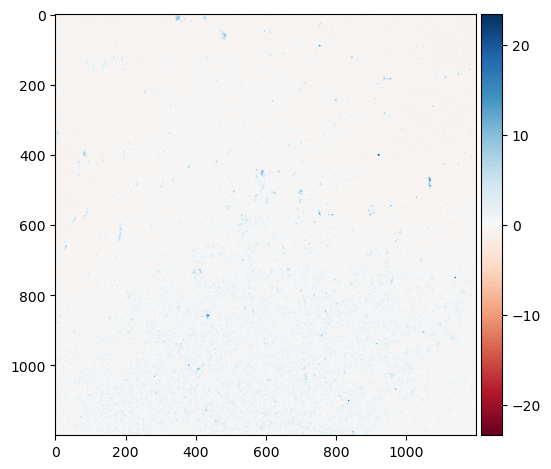

In [6]:
imshow(img)
img.shape

## Generating a feature stack
Pixel classifiers such as the random forest classifier takes multiple images as input. We typically call these images a feature stack because for every pixel exist now multiple values (features). In the following example we create a feature stack containing three features:
* The original pixel value
* The pixel value after a Gaussian blur
* The pixel value of the Gaussian blurred image processed through a Sobel operator.

Thus, we denoise the image and detect edges. All three images serve the pixel classifier to differentiate positive an negative pixels.

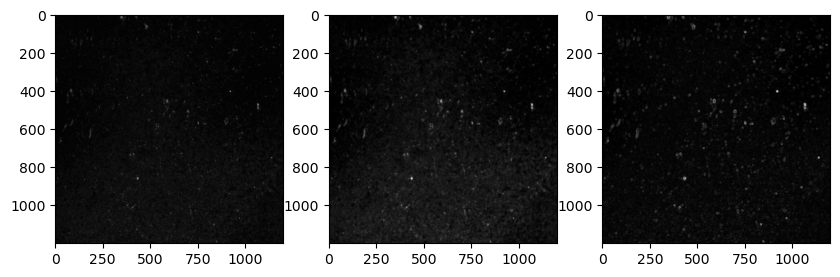

In [8]:
from skimage import filters

def generate_feature_stack(image):
    # determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here.
    feature_stack = [
        image.ravel(),
        blurred.ravel(),
        edges.ravel()
    ]

    # return stack as numpy-array
    return np.asarray(feature_stack)

feature_stack = generate_feature_stack(img)

# show feature images
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1, 3, figsize=(10,10))


%gui qt
# reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
axes[0].imshow(feature_stack[0].reshape(img.shape), cmap=plt.cm.gray)
axes[1].imshow(feature_stack[1].reshape(img.shape), cmap=plt.cm.gray)
axes[2].imshow(feature_stack[2].reshape(img.shape), cmap=plt.cm.gray)

## Formating data
We now need to format the input data so that it fits to what scikit learn expects. Scikit-learn asks for an array of shape (n, m) as input data and (n) annotations. n corresponds to number of pixels and m to number of features. In our case m = 3.

In [9]:
def format_data(feature_stack, annotation):
    # reformat the data to match what scikit-learn expects
    # transpose the feature stack
    X = feature_stack.T
    # make the annotation 1-dimensional
    y = annotation.ravel()

    # remove all pixels from the feature and annotations which have not been annotated
    mask = y > 0
    X = X[mask]
    y = y[mask]

    return X, y

## Interactive segmentation
We can also use napari to annotate some regions as negative (label = 1) and positive (label = 2).

In [10]:
%gui qt
import napari

# start napari
viewer = napari.Viewer()

In [11]:
viewer.add_image(img)

<Image layer 'img' at 0x7f916899c880>

In [12]:
# if starting from scratch
labels = viewer.add_labels(np.zeros(img.shape,dtype='uint8'))


# # if already having results
# result_2d = imread("manual annotations.tif")
# labels = viewer.add_labels(result_2d+1)

# Now open the napari viewer and draw (it doesnt need much)
**Draw labels of cells with 2 and background with 1 (not 1 and 0)**

# Are you done with drawing for now?

Retrieve the annotations from the napari layer:

In [15]:
# get the drawings first
manual_annotations = labels.data


In [16]:

# and immediately save them
imsave(manual_labels_filename, manual_annotations)

/tmp/ipykernel_19930/3697304232.py:2: UserWarning: manual_annotations_transwell_denoised_Mutant-3-1.tif is a low contrast image
  imsave(manual_labels_filename, manual_annotations)


/home/eric/miniconda3/envs/devbio-napari-env/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


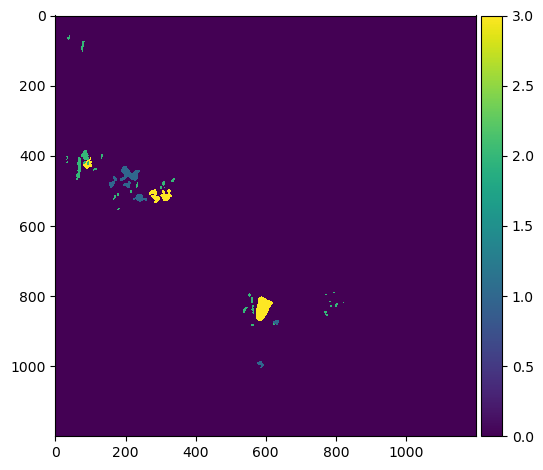

In [17]:
imshow(manual_annotations, vmin=0, vmax=3)

# Training begins

In [18]:
# choose img
feature_stack = generate_feature_stack(img)

In [19]:
# train classifier if not trained yet
classifier = RandomForestClassifier()

# if i have a pretrained model
# classifier = classifier.load(filename) 

X, y = format_data(feature_stack, manual_annotations)


## Gridsearch for the best parameters

In [20]:

param_grid = {
    'n_estimators': [50,100],  # Vary the number of trees
    'max_depth': [2, 3],       # Vary the maximum depth of trees
}


grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X, y)  # X and y are your training data and labels, respectively



GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3], 'n_estimators': [50, 100]})

In [21]:
grid_search.cv_results_


{'mean_fit_time': array([0.26475968, 0.53231473, 0.34235439, 0.67313218]),
 'std_fit_time': array([0.0176586 , 0.01867885, 0.01143006, 0.01678939]),
 'mean_score_time': array([0.01557827, 0.0302846 , 0.01718826, 0.03142686]),
 'std_score_time': array([0.00127403, 0.00241763, 0.00104465, 0.00113472]),
 'param_max_depth': masked_array(data=[2, 2, 3, 3],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2, 'n_estimators': 50},
  {'max_depth': 2, 'n_estimators': 100},
  {'max_depth': 3, 'n_estimators': 50},
  {'max_depth': 3, 'n_estimators': 100}],
 'split0_test_score': array([0.74714434, 0.75700935, 0.75233645, 0.75545171]),
 'split1_test_score': array([0.93042575, 0.93094496, 0.92211838, 0.9278297 ]),
 'split2_test_score': array([0.88883117, 0.89194805,

[[0.85312441 0.85520125]
 [0.85364421 0.85520174]]


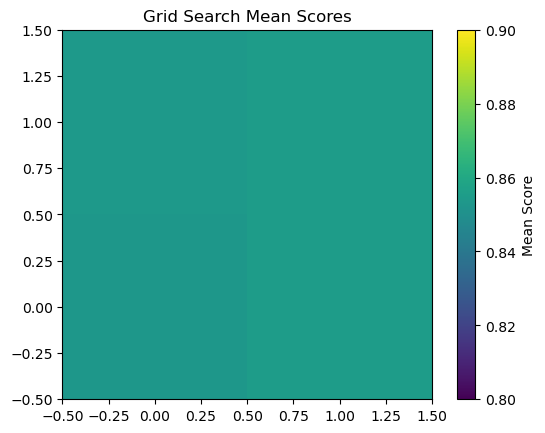

In [31]:
results = grid_search.cv_results_

# Extract the mean scores and reshape them into a grid
scores = np.array(results['mean_test_score']).reshape(len(param_grid['n_estimators']),
                                                      len(param_grid['max_depth']))

print(scores)

# Create a heatmap of the mean scores
plt.imshow(scores, cmap='viridis', origin='lower')
plt.colorbar(label='Mean Score')
plt.clim(0.8,0.9)
plt.title('Grid Search Mean Scores')
plt.show()

In [32]:
best_classifier = grid_search.best_estimator_


In [42]:
# save classifier 
import pickle
import time

timestr = time.strftime("%Y%m%d-%H%M%S")

pickle.dump(best_classifier, open('../models/RandomForestClassifier_transwell/'+ timestr + '_' + filename, 'wb'))

# Now go to the other notebook for prediction. 